In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
file_path = r"drive_cycles\drive_cycle_itr6.xlsx"
dc_pred = pd.read_excel(file_path)

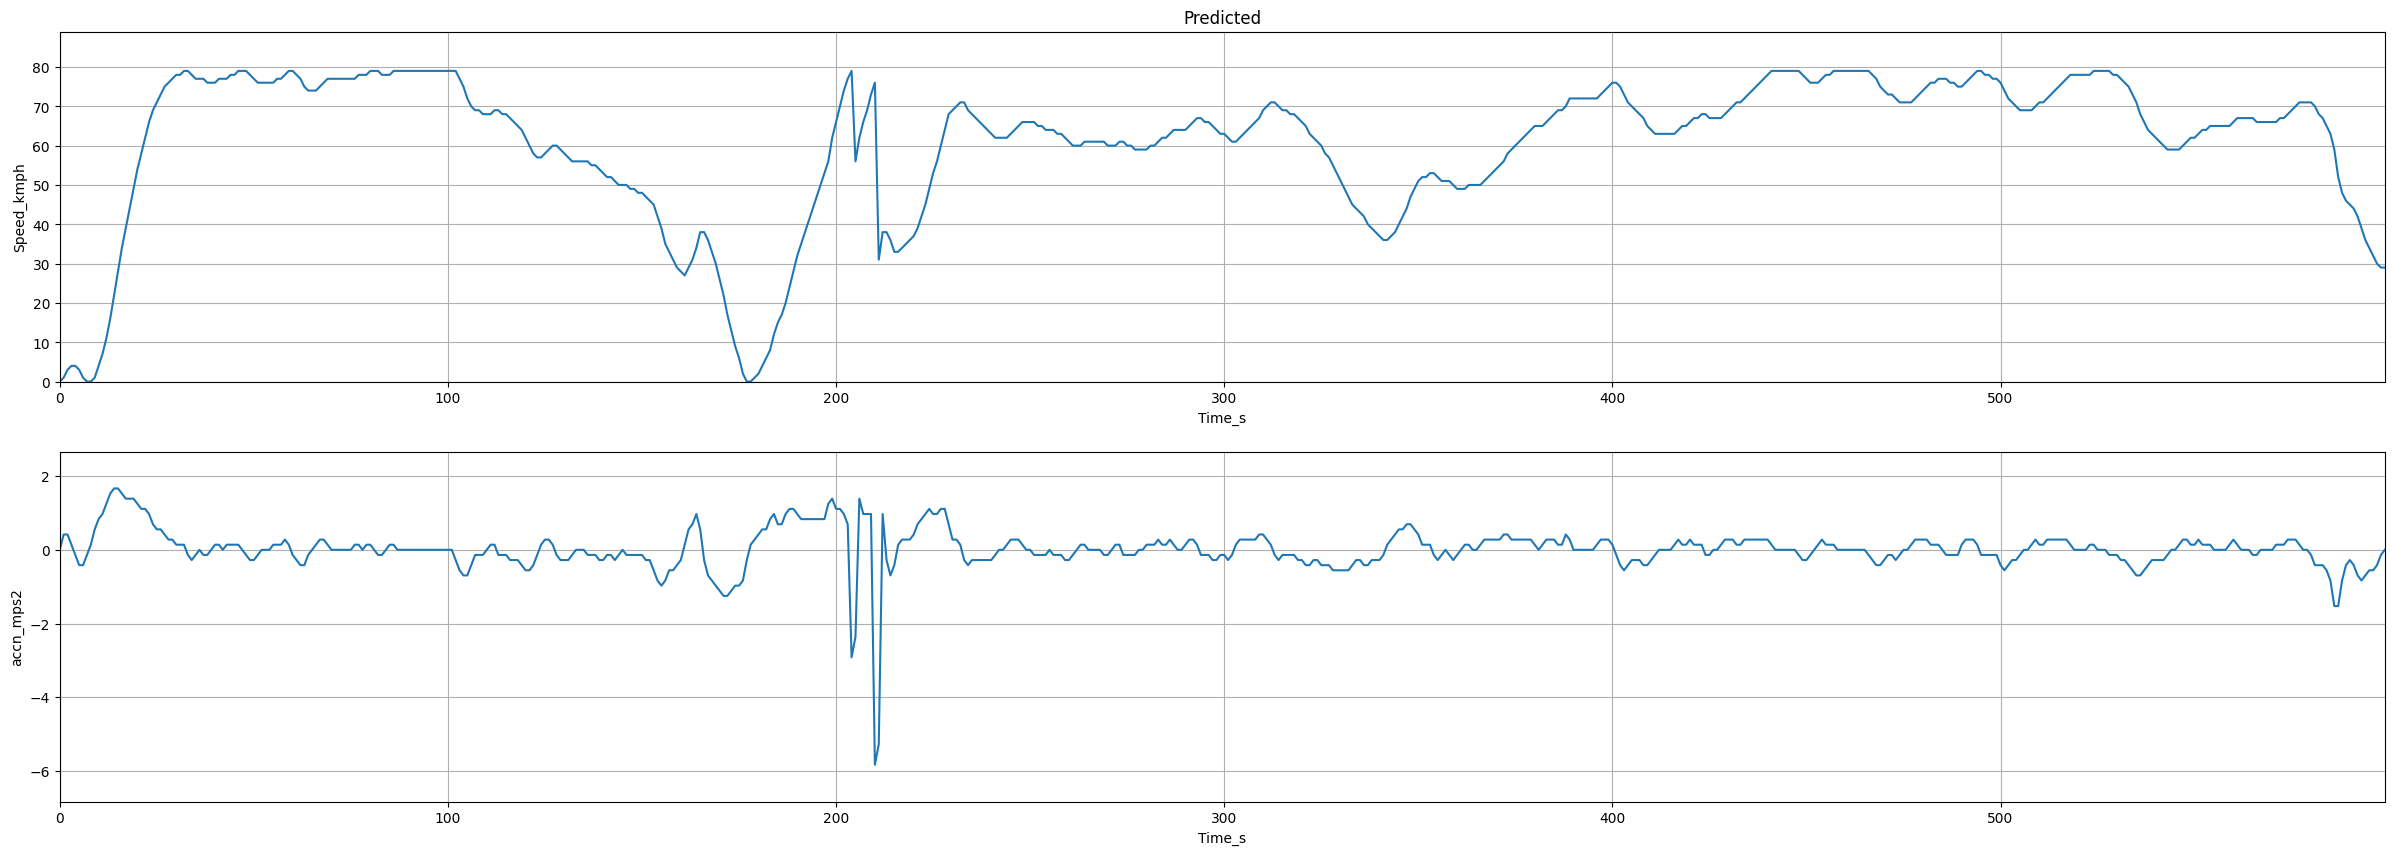

In [4]:
fig,ax = plt.subplots(2,1,figsize=[30,10])

#Speed plot
ax[0].plot(dc_pred['time_s'],dc_pred['speed_kmph'])
ax[0].set_xlim([0, dc_pred['time_s'].max()])
# ax[0].set_xlim([1000, 1200])
ax[0].set_ylim([0, dc_pred['speed_kmph'].max()+10])
ax[0].set_title('Predicted')
ax[0].set_xlabel('Time_s')
ax[0].set_ylabel('Speed_kmph')
ax[0].grid()

#Accn plot
ax[1].plot(dc_pred['time_s'],dc_pred['accn_mps2'])
ax[1].set_xlim([0, dc_pred['time_s'].max()])
# ax[1].set_xlim([1000, 1200])
ax[1].set_ylim([dc_pred['accn_mps2'].min()-1, dc_pred['accn_mps2'].max()+1])
ax[1].set_xlabel('Time_s')
ax[1].set_ylabel('accn_mps2')
ax[1].grid()


In [5]:
# import statsmodels.api as sm

# y_lowess = sm.nonparametric.lowess(dc_pred['accn_mps2'], dc_pred['time_s'], frac = 0.01)
# dc_pred['smoooth_accn_lowess'] = y_lowess[:, 1] # 30 % lowess smoothing
# plt.rcParams["figure.figsize"] = (20,3)
# plt.plot(dc_pred['time_s'], dc_pred['smoooth_accn_lowess'])
# plt.plot(dc_pred['time_s'],dc_pred['accn_mps2'])
# plt.show()

In [6]:
# accn_noise_lowess = dc_pred['accn_mps2'] - dc_pred['smoooth_accn_lowess']
# plt.rcParams["figure.figsize"] = (20,3)
# plt.plot(dc_pred['time_s'], accn_noise_lowess)
# # plt.plot(dc_pred['time_s'],dc_pred['accn_mps2'])
# plt.show()

In [7]:
from scipy.interpolate import splrep, splev
from math import sqrt
# ideal range for s where m is the length of data
m = len(dc_pred)
p = (m-sqrt(2*m),m+sqrt(2*m))
print(p)

(565.3589838486224, 634.6410161513776)


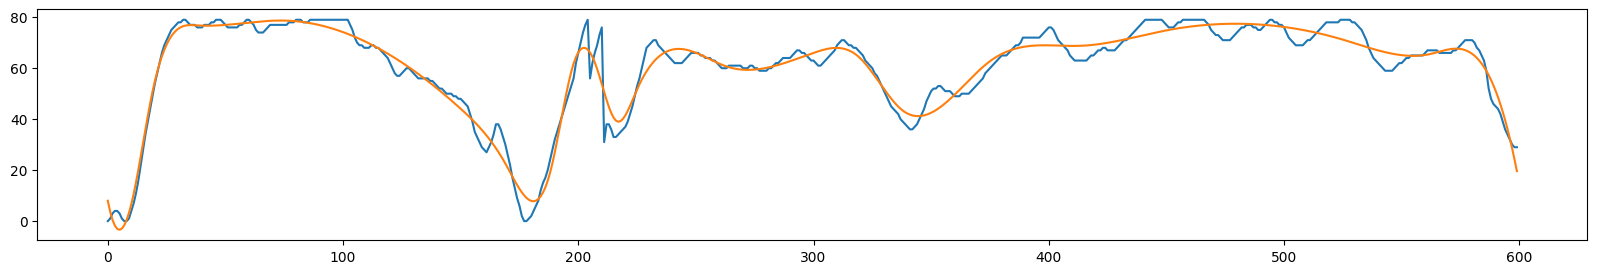

In [12]:
plt.figure()
plt.rcParams["figure.figsize"] = (20,3)
bspl = splrep(dc_pred['time_s'],dc_pred['speed_kmph'],s=10000)
dc_pred['smooth_speed'] = splev(dc_pred['time_s'],bspl)
plt.plot(dc_pred['time_s'],dc_pred['speed_kmph'])
plt.plot(dc_pred['time_s'],dc_pred['smooth_speed'])
plt.show()

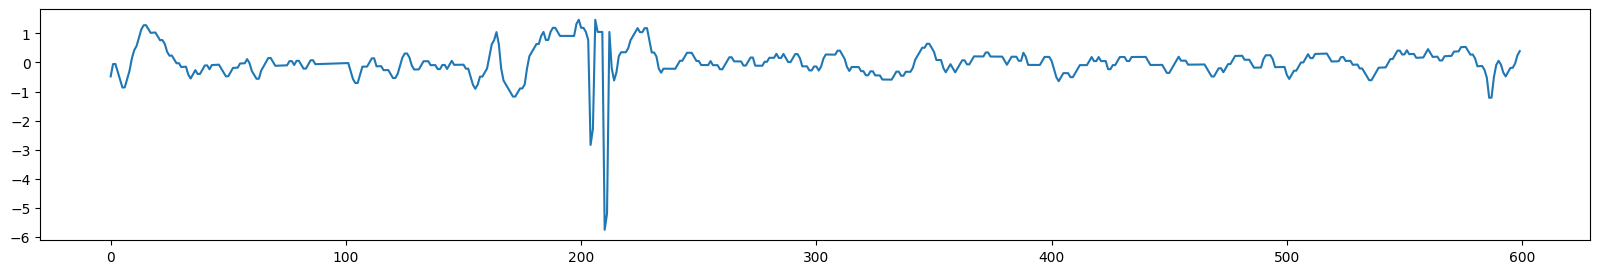

In [17]:
dc_pred['accn_noise_splrep'] = dc_pred['accn_mps2'] - dc_pred['smooth_speed']
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(dc_pred['time_s'], dc_pred['accn_noise_splrep'])
plt.show()

In [10]:
lower_threshold = -2.0  # Set your lower threshold value
upper_threshold = 2.0  # Set your upper threshold value
filtered_df = dc_pred[(dc_pred['accn_noise_splrep'] >= lower_threshold) & (dc_pred['accn_noise_splrep'] <= upper_threshold)]
filtered_df.reset_index(drop=True, inplace=True)

C:\Users\Dhanveerraj JM\AppData\Local\Temp\ipykernel_3740\1653463634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['accn_noise_splrep'] = filtered_df['accn_mps2'] - filtered_df['smoooth_accn_splrep']


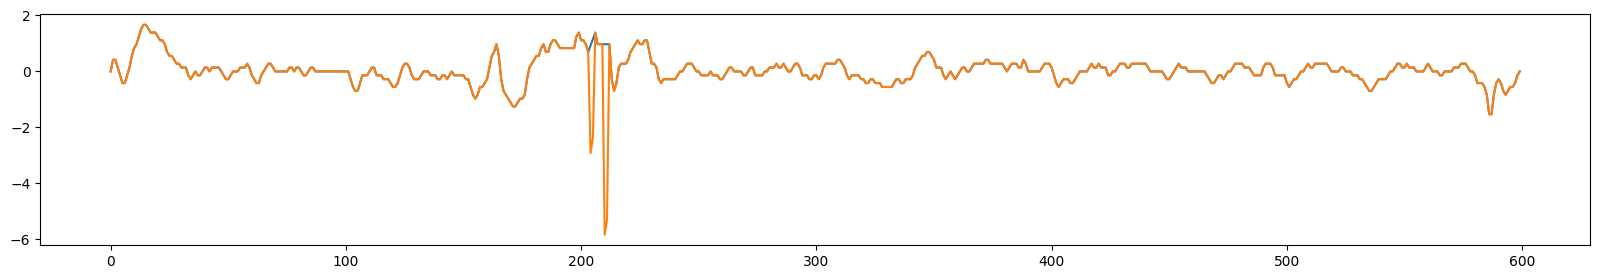

In [19]:
filtered_df['accn_noise_splrep'] = filtered_df['accn_mps2'] - filtered_df['smooth_speed']
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(filtered_df['time_s'], filtered_df['accn_mps2'])
plt.plot(dc_pred['time_s'], dc_pred['accn_mps2'])
plt.show()

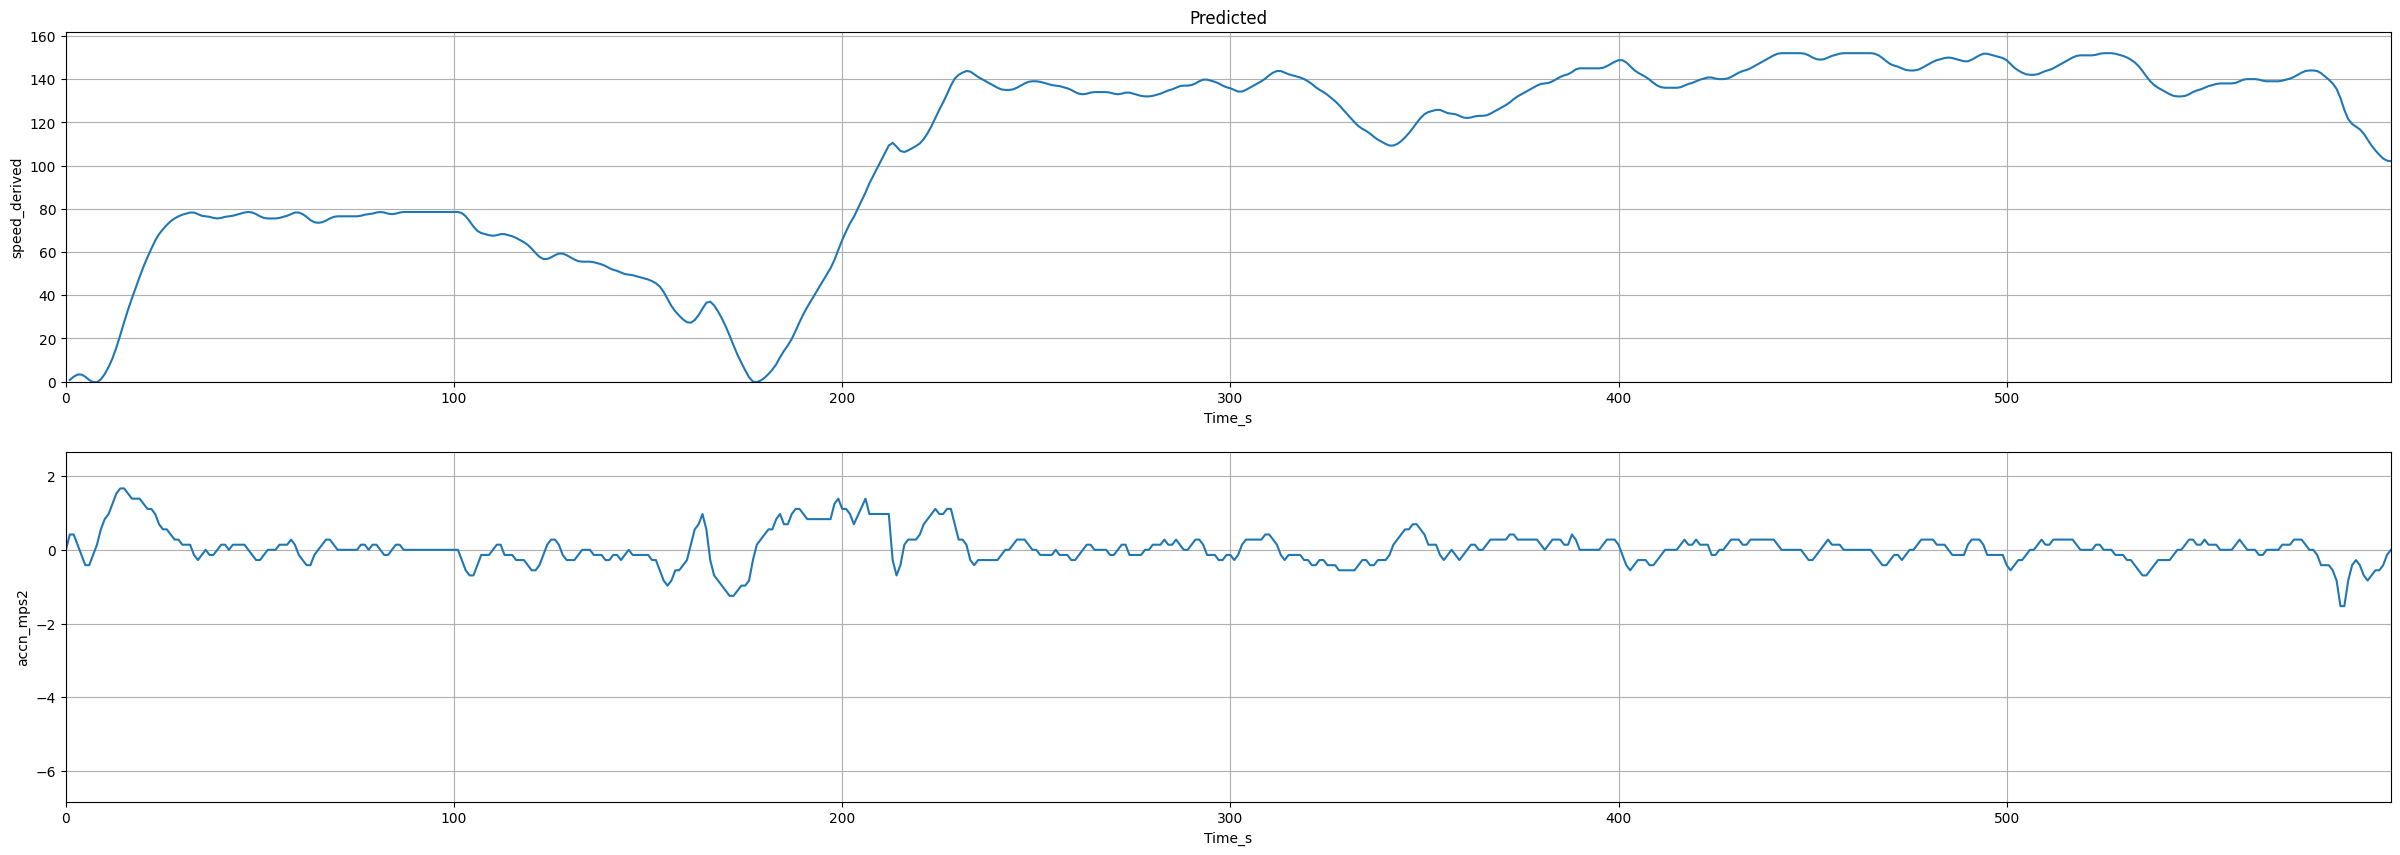

In [20]:
fig,ax = plt.subplots(2,1,figsize=[30,10])


time_interval = filtered_df['time_s'].diff()  # Calculate time intervals
time_interval.iloc[0] = 0  # Set the first interval to 0 to maintain dimensions

# Trapezoidal integration to calculate velocity
speed_derived = ((0.5 * (filtered_df['accn_mps2'] + filtered_df['accn_mps2'].shift(1)) * time_interval).cumsum())*18/5

# Create a new DataFrame for velocity
speed_df = pd.DataFrame({
    "time_s": filtered_df['time_s'],
    'speed_derived': speed_derived
})


#Speed plot
ax[0].plot(speed_df['time_s'],speed_df['speed_derived'])
ax[0].set_xlim([0, speed_df['time_s'].max()])
# ax[0].set_xlim([1000, 1200])
ax[0].set_ylim([0, speed_df['speed_derived'].max()+10])
ax[0].set_title('Predicted')
ax[0].set_xlabel('Time_s')
ax[0].set_ylabel('speed_derived')
ax[0].grid()

#Accn plot
ax[1].plot(filtered_df['time_s'],filtered_df['accn_mps2'])
ax[1].set_xlim([0, filtered_df['time_s'].max()])
# ax[1].set_xlim([1000, 1200])
ax[1].set_ylim([dc_pred['accn_mps2'].min()-1, filtered_df['accn_mps2'].max()+1])
ax[1].set_xlabel('Time_s')
ax[1].set_ylabel('accn_mps2')
ax[1].grid()


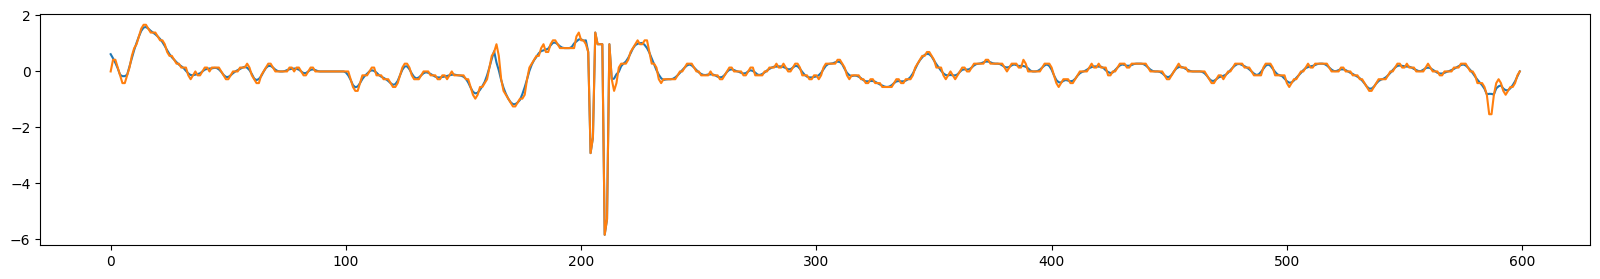

In [12]:
import statsmodels.api as sm

y_lowess = sm.nonparametric.lowess(dc_pred['accn_mps2'], dc_pred['time_s'], frac = 0.01)
dc_pred['smoooth_accn_lowess'] = y_lowess[:, 1] # 30 % lowess smoothing
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(dc_pred['time_s'], dc_pred['smoooth_accn_lowess'])
plt.plot(dc_pred['time_s'],dc_pred['accn_mps2'])
plt.show()

In [13]:
print(len(dc_pred), len(filtered_df))

600 596


In [14]:
# polynomial fit - computationally intensive 

# import numpy as np
# import matplotlib.pyplot as plt

# plt.figure()
# plt.rcParams["figure.figsize"] = (20,3)
# poly = np.polyfit(dc_pred['time_s'],dc_pred['speed_kmph'],100)
# poly_y = np.poly1d(poly)(dc_pred['time_s'])
# plt.plot(dc_pred['time_s'],poly_y)
# plt.plot(dc_pred['time_s'],dc_pred['speed_kmph'])
# plt.show()